<img align="right" width="400" src="https://drive.google.com/thumbnail?id=1rPeHEqFWHJcauZlU82a4hXM10TUjmHxM&sz=s4000" alt="FHNW Logo">



# Transformers Fine Tuning

by Fabian Märki

## Summary
The aim of this notebook is to show how to further fine tune a pretrained model for sequence classification (the model has been fine tuned for a similar task already). In a first round, only the newly added classification head is trained (all other layers are frozen - the idea is to adjust the class vectors of the classification head to the pretrained feature extractor). In a second round, the complete model is trained (by unfreezing all layers).   


## Links
- [Fine-tune a pretrained model](https://huggingface.co/docs/transformers/training)
- [Course](https://huggingface.co/course/chapter1) on how to use Huggingface's transformer models (from simple using pipelines to complex implementing the training loop).
- [Notebooks](https://huggingface.co/docs/transformers/notebooks) on different topics (fine tuning, translation, summarization, question answering, audio classification, image classification etc.)

This notebook contains assigments: <font color='red'>Questions are written in red.</font>

<a href="https://colab.research.google.com/github/markif/NLP_LAB_CAS/blob/master/Transformers_Text_Classifier_FineTuning_a_FineTunded_Model_in_2_Steps.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

<font color='red'>**TASK: Go through [these slides](https://drive.switch.ch/index.php/s/H5t31sTaqi4Op1o) to get an intuition on the classification task.**</font>

In [1]:
%%capture

!pip install 'fhnw-nlp-utils>=0.11.0,<0.12.0'

from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.storage import load_dataframe

import pandas as pd
import numpy as np

**Make sure that a GPU is available (see [here](https://www.tutorialspoint.com/google_colab/google_colab_using_free_gpu.htm))!!!**

In [2]:
from fhnw.nlp.utils.system import set_log_level
from fhnw.nlp.utils.system import system_info

set_log_level()
print(system_info())

OS name: posix
Platform name: Linux
Platform release: 6.14.0-33-generic
Python version: 3.11.13
CPU cores: 6
RAM: 31.11GB total and 23.86GB available
GPU is a NVIDIA GeForce RTX 2070 with Max-Q Design with 7967MB
Torch version: 2.8.0+cu128
Tensorflow version: 2.20.0


In [3]:
%%time
download("https://drive.switch.ch/index.php/s/0hE8wO4FbfGIJld/download", "data/german_doctor_reviews_tokenized.parq")
data = load_dataframe("data/german_doctor_reviews_tokenized.parq")

CPU times: user 4.84 s, sys: 772 ms, total: 5.61 s
Wall time: 3.31 s


In [4]:
# remove all neutral sentimens - make it to a binary classification task
data = data.loc[(data["label"] != "neutral")]
data.shape

(331197, 9)

In [5]:
data.head(3)

,text_original,rating,text,label,sentiment,token_clean,text_clean,token_stem,token_clean_stopwords
0,Ich bin franzose und bin seit ein paar Wochen ...,2.0,Ich bin franzose und bin seit ein paar Wochen ...,positive,1,"[ich, bin, franzose, und, bin, seit, ein, paar...",ich bin franzose und bin seit ein paar wochen ...,"[franzos, seit, paar, woch, muench, zahn, schm...","[franzose, seit, paar, wochen, muenchen, zahn,..."
1,Dieser Arzt ist das unmöglichste was mir in me...,6.0,Dieser Arzt ist das unmöglichste was mir in me...,negative,-1,"[dieser, arzt, ist, das, unmöglichste, was, mi...",dieser arzt ist das unmöglichste was mir in me...,"[arzt, unmog, leb, je, begegnet, unfreund, her...","[arzt, unmöglichste, leben, je, begegnet, unfr..."
2,Hatte akute Beschwerden am Rücken. Herr Magura...,1.0,Hatte akute Beschwerden am Rücken. Herr Magura...,positive,1,"[hatte, akute, beschwerden, am, rücken, ., her...",hatte akute beschwerden am rücken . herr magur...,"[akut, beschwerd, ruck, magura, erst, arzt, wi...","[akute, beschwerden, rücken, magura, erste, ar..."


In [6]:
%%capture

!pip install torch
!pip install transformers
!pip install datasets
!pip install evaluate
!pip install accelerate

In [7]:
from fhnw.nlp.utils.transformers import dataframes_to_dataset
from fhnw.nlp.utils.transformers import get_compute_device

<font color='red'>**TASK: Go to the [Huggingface models](https://huggingface.co/models?pipeline_tag=text-classification&language=de&sort=trending&search=sentiment) page and search for a pretrained model that fits this task (think about suitable filters).**</font>

<font color='red'>**You might want to try a different model...**</font>

In [8]:
params = {
    # modify batch_size in case you experience memory issues
    "batch_size": 8,
    "X_column_name": "text",
    "y_column_name": "label",
    "compute_device": get_compute_device(),
    # see https://huggingface.co/philschmid/distilbert-base-multilingual-cased-sentiment-2/tree/main
    "transformers_model_name": "philschmid/distilbert-base-multilingual-cased-sentiment-2",
}

In [9]:
datasets = dataframes_to_dataset(params, data)

Casting the dataset:   0%|          | 0/198718 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/66239 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/66240 [00:00<?, ? examples/s]

Changing max_length (to e.g. `input_sequence_length` or even smaller) can greatly speedup training and can even help to converge training.

In [10]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(params["transformers_model_name"])

def tokenize_function(examples):
    X_column_name = params.get("X_column_name", "text")
    input_sequence_length = params.get("input_sequence_length", 256)

    # see https://huggingface.co/docs/transformers/pad_truncation for more information about the parameters
    return tokenizer(
        examples[X_column_name], 
        padding=True,
        truncation=True,
        max_length=input_sequence_length,
    )

tokenized_datasets = datasets.map(tokenize_function, batched=True)

Map:   0%|          | 0/198718 [00:00<?, ? examples/s]

Map:   0%|          | 0/66240 [00:00<?, ? examples/s]

Map:   0%|          | 0/66239 [00:00<?, ? examples/s]

In [11]:
%%time

print("Text: ", tokenizer.convert_ids_to_tokens(tokenized_datasets["test"]["input_ids"][0])[0:30])
print("IDs: ", tokenized_datasets["test"]["input_ids"][0][0:30])

Text:  ['[CLS]', 'Se', '##hr', 'em', '##pha', '##tisch', 'und', 'fac', '##hlich', 'kom', '##pet', '##ent', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
IDs:  [101, 11045, 16757, 10266, 37590, 29449, 10130, 107159, 76907, 12240, 19094, 11405, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
CPU times: user 3.56 ms, sys: 24 μs, total: 3.58 ms
Wall time: 3.12 ms


In [12]:
# only use a subset of the dataset to speedup training (as this notebook showcases the training task)
#train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
#eval_dataset = tokenized_datasets["test"].select(range(1000))

# use the full dataset
train_dataset = tokenized_datasets["train"].shuffle(seed=42)
eval_dataset = tokenized_datasets["test"]

In [13]:
classlabel = datasets["train"].features[params["y_column_name"]]
label2id = { label: classlabel.str2int(label) for label in classlabel.names }
id2label = { i: classlabel.int2str(i) for i in label2id.values() }

Setup the new labels and adjust the model config.

In [14]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(params["transformers_model_name"])

Print the model config to see the labels of the model.

See also [here](https://github.com/huggingface/transformers/issues/5905) and [here](https://github.com/huggingface/transformers/blob/6e8a38568eb874f31eb49c42285c3a634fca12e7/examples/token-classification/run_ner.py#L146)

In [15]:
model.config

DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "dtype": "float32",
  "hidden_dim": 3072,
  "id2label": {
    "0": "negative",
    "1": "neutral",
    "2": "positive"
  },
  "initializer_range": 0.02,
  "label2id": {
    "negative": "0",
    "neutral": "1",
    "positive": "2"
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.57.0",
  "vocab_size": 119547
}

Setup the new labels and adjust the model config.

In [16]:
model.config.num_labels = len(id2label)
model.config.id2label = id2label
model.config.label2id = label2id

model.config

DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "dtype": "float32",
  "hidden_dim": 3072,
  "id2label": {
    "0": "negative",
    "1": "positive"
  },
  "initializer_range": 0.02,
  "label2id": {
    "negative": 0,
    "positive": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.57.0",
  "vocab_size": 119547
}

Reinitiallize the classification layer to match the number of the new labels (and do not forget to adjust the model's <code>num_labels</code>.

In [17]:
import torch

model.classifier = torch.nn.Linear(in_features=model.classifier.in_features, out_features=model.config.num_labels, bias=True)
model.num_labels = model.config.num_labels

Check which layers are trained.

In [18]:
for name, param in model.named_parameters():
     print(name, param.requires_grad)

distilbert.embeddings.word_embeddings.weight True
distilbert.embeddings.position_embeddings.weight True
distilbert.embeddings.LayerNorm.weight True
distilbert.embeddings.LayerNorm.bias True
distilbert.transformer.layer.0.attention.q_lin.weight True
distilbert.transformer.layer.0.attention.q_lin.bias True
distilbert.transformer.layer.0.attention.k_lin.weight True
distilbert.transformer.layer.0.attention.k_lin.bias True
distilbert.transformer.layer.0.attention.v_lin.weight True
distilbert.transformer.layer.0.attention.v_lin.bias True
distilbert.transformer.layer.0.attention.out_lin.weight True
distilbert.transformer.layer.0.attention.out_lin.bias True
distilbert.transformer.layer.0.sa_layer_norm.weight True
distilbert.transformer.layer.0.sa_layer_norm.bias True
distilbert.transformer.layer.0.ffn.lin1.weight True
distilbert.transformer.layer.0.ffn.lin1.bias True
distilbert.transformer.layer.0.ffn.lin2.weight True
distilbert.transformer.layer.0.ffn.lin2.bias True
distilbert.transformer.lay

Freeze all weights/biases for training and only allow the classification layer to be trained.

In [19]:
# freeze weights/bias for training (only train classifier)

for name, param in model.named_parameters():
     if "classifier" not in name: 
        param.requires_grad = False

Double check

In [20]:
for name, param in model.named_parameters():
     print(name, param.requires_grad)

distilbert.embeddings.word_embeddings.weight False
distilbert.embeddings.position_embeddings.weight False
distilbert.embeddings.LayerNorm.weight False
distilbert.embeddings.LayerNorm.bias False
distilbert.transformer.layer.0.attention.q_lin.weight False
distilbert.transformer.layer.0.attention.q_lin.bias False
distilbert.transformer.layer.0.attention.k_lin.weight False
distilbert.transformer.layer.0.attention.k_lin.bias False
distilbert.transformer.layer.0.attention.v_lin.weight False
distilbert.transformer.layer.0.attention.v_lin.bias False
distilbert.transformer.layer.0.attention.out_lin.weight False
distilbert.transformer.layer.0.attention.out_lin.bias False
distilbert.transformer.layer.0.sa_layer_norm.weight False
distilbert.transformer.layer.0.sa_layer_norm.bias False
distilbert.transformer.layer.0.ffn.lin1.weight False
distilbert.transformer.layer.0.ffn.lin1.bias False
distilbert.transformer.layer.0.ffn.lin2.weight False
distilbert.transformer.layer.0.ffn.lin2.bias False
distilbe

In [21]:
import numpy as np
import evaluate

#metric = evaluate.load("accuracy")
metric = evaluate.combine(["accuracy", "recall", "precision", "f1"])

In [22]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [23]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    num_train_epochs = params.get("training_epochs", 2),
    report_to = "none",
    output_dir = "test_trainer", 
    eval_strategy = "epoch",
    save_strategy = "epoch",
    save_total_limit = 1,
    #eval_strategy ="steps",
    #save_strategy = "steps",
    #eval_steps = 100, # Evaluation and Save happens every 100 steps 
    #save_total_limit = 3, # Only last 3 models are saved. Older ones are deleted.
    load_best_model_at_end = True,
    metric_for_best_model = "f1",
    auto_find_batch_size = True,
    #per_device_train_batch_size = params.get("batch_size", 4),  # batch size per device during training
    #per_device_eval_batch_size = params.get("batch_size", 4), # batch size for evaluation
)

In [24]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

In [25]:
%%time

train_result = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,0.140600,0.150639,0.942164,0.975199,0.961129,0.968113
2,0.151100,0.148031,0.942134,0.974310,0.961906,0.968069


CPU times: user 52min 44s, sys: 6.74 s, total: 52min 51s
Wall time: 52min 49s


Let's store all this work fist.

In [26]:
model_path = "data/"+params["transformers_model_name"]+"-sentiment-classifier"

model.save_pretrained(model_path)
_ = tokenizer.save_pretrained(model_path)

Remark: I experienced an OOM during startup of the second finetuning step. In this case you need to restart and reload the model (see commented code below).

In [27]:
# model_path = "data/"+params["transformers_model_name"]+"-sentiment-classifier"

#tokenizer = AutoTokenizer.from_pretrained(model_path, local_files_only=True)
#model = AutoModelForSequenceClassification.from_pretrained(model_path, local_files_only=True)

Unfreeze all layers to allow for a full model training.

In [28]:
for name, param in model.named_parameters():
        param.requires_grad = True

Setup trainer again (initialize with fresh parameters).

In [29]:
training_args.num_train_epochs = 3

In [30]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

In [31]:
%%time

train_result = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,0.121400,0.152331,0.966621,0.992454,0.971106,0.981664
2,0.083300,0.100668,0.975120,0.989117,0.983346,0.986223
3,0.065400,0.098221,0.976796,0.987206,0.987023,0.987114


CPU times: user 3h 49min 25s, sys: 20.4 s, total: 3h 49min 46s
Wall time: 3h 49min 37s


In [32]:
trainer.evaluate()

{'eval_loss': 0.09822086244821548,
 'eval_accuracy': 0.9767961472848322,
 'eval_recall': 0.987205500125765,
 'eval_precision': 0.9870234382858867,
 'eval_f1': 0.987114460811026,
 'eval_runtime': 381.6006,
 'eval_samples_per_second': 173.582,
 'eval_steps_per_second': 21.698,
 'epoch': 3.0}

In [33]:
model_path = "data/"+params["transformers_model_name"]+"-sentiment-full"

model.save_pretrained(model_path)
_ = tokenizer.save_pretrained(model_path)

load the model (in case you need to restart)

In [34]:
#tokenizer = AutoTokenizer.from_pretrained(model_path, local_files_only=True)
#model = AutoModelForSequenceClassification.from_pretrained(model_path, local_files_only=True)

Let's put this into a Pipeline (see also [here](https://huggingface.co/docs/transformers/add_new_pipeline))

In [35]:
from transformers import Pipeline

class DoctorReviewsSentimentPipeline(Pipeline):
    
    def _sanitize_parameters(self, **kwargs):
        preprocess_kwargs = {}
        if "input_sequence_length" in kwargs:
            preprocess_kwargs["input_sequence_length"] = kwargs["input_sequence_length"]
        return preprocess_kwargs, {}, {}

    def preprocess(self, text, input_sequence_length=256):
        # max_length can have a major performance impact (choose it wisely).
        # if there are occasional very long sentence compared to the others, 
        # the whole batch will need to be 256 tokens long (i.e. [batch_size, 256]),
        # leading to a slowdown (on bigger batches the program might even crash).
        #
        # Therefore it could make sense to choose a shorter input_sequence_length
        # (however, there is a tradeoff between model performance vs. compute performance)
        return self.tokenizer(text, 
                              padding=True, 
                              truncation=True, 
                              max_length=input_sequence_length, 
                              return_tensors=self.framework)

    def _forward(self, model_inputs):
        return self.model(**model_inputs)

    def postprocess(self, model_outputs):
        import torch
        import numpy as np 
        
        predictions = np.argmax(model_outputs.logits, axis=-1)
        labels = [self.model.config.id2label[pred.item()] for (idx,pred) in enumerate(predictions)]
        
        if len(labels) == 1:
            return labels[0]
        else:
            return labels

In [36]:
from transformers.pipelines import PIPELINE_REGISTRY
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification

PIPELINE_REGISTRY.register_pipeline(
    "doctor-reviews-sentiment",
    pipeline_class=DoctorReviewsSentimentPipeline,
    pt_model=AutoModelForSequenceClassification,
    tf_model=TFAutoModelForSequenceClassification,
    #default={"pt": (model_name, model_version)},
    type="text",
)

/tmp/ipykernel_74/456468740.py:5: FutureWarning: `tf_model` is deprecated and will be removed in version 5.0.0 for `PipelineRegistry.register_pipeline`.
  PIPELINE_REGISTRY.register_pipeline(


In [37]:
from transformers import pipeline

sentiment_pipeline = pipeline("doctor-reviews-sentiment", 
                              model = model_path,
                              device = params.get("compute_device", "cpu"),
                              input_sequence_length = params.get("input_sequence_length", 256)
                             )

Device set to use cuda:0


In [38]:
sentiment_pipeline(data[params["X_column_name"]].head(3).tolist())

['positive', 'negative', 'positive']

In [39]:
from transformers.pipelines.pt_utils import KeyDataset

batch_size = params.get("batch_size", 16)

dataset_test = datasets["test"]
dataset_val = datasets["validation"]
dataset_train = datasets["train"]

pred_iter_test = sentiment_pipeline(KeyDataset(dataset_test, params["X_column_name"]), batch_size=batch_size)
pred_iter_val = sentiment_pipeline(KeyDataset(dataset_val, params["X_column_name"]), batch_size=batch_size)
pred_iter_train = sentiment_pipeline(KeyDataset(dataset_train, params["X_column_name"]), batch_size=batch_size)

In [40]:
%%time 

# evaluate PipelineIterator
preds_test = [x for x in pred_iter_test]
preds_val = [x for x in pred_iter_val]
preds_train = [x for x in pred_iter_train]

CPU times: user 24min 56s, sys: 190 ms, total: 24min 56s
Wall time: 24min 56s


In [41]:
labels_test = [model.config.id2label[label] for label in dataset_test["label"]]
labels_val = [model.config.id2label[label] for label in dataset_val["label"]]
labels_train = [model.config.id2label[label] for label in dataset_train["label"]]

Set Population: 331197
Accuracy: 0.9824


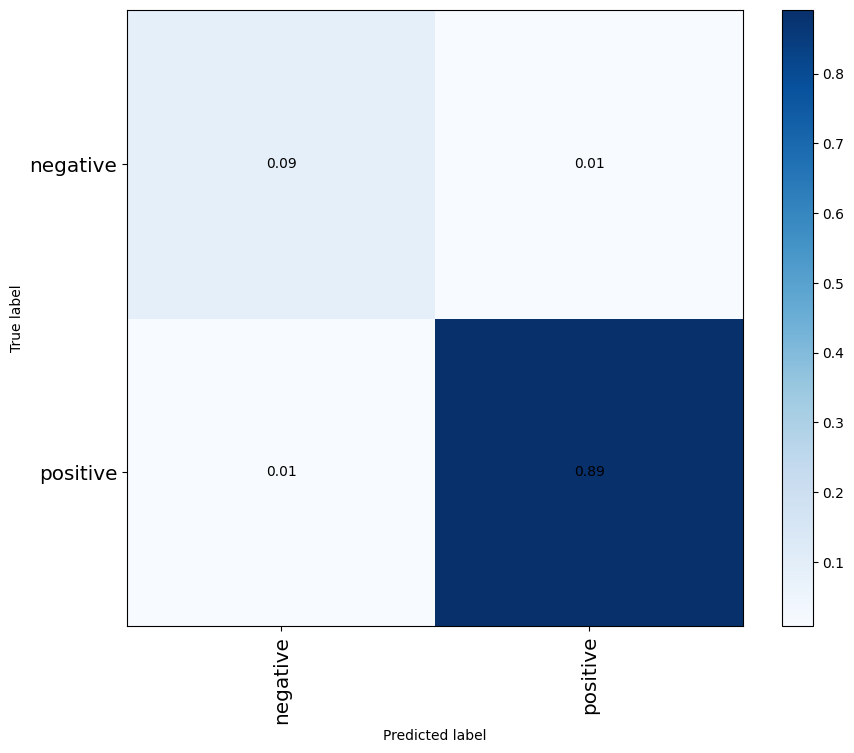

              precision    recall  f1-score   support

    negative       0.91      0.91      0.91     33023
    positive       0.99      0.99      0.99    298174

    accuracy                           0.98    331197
   macro avg       0.95      0.95      0.95    331197
weighted avg       0.98      0.98      0.98    331197



In [42]:
from fhnw.nlp.utils.ploting import report_classification_results

report_classification_results(params, labels_test + labels_val + labels_train, preds_test + preds_val + preds_train)

Set Population: 66239
Accuracy: 0.9768


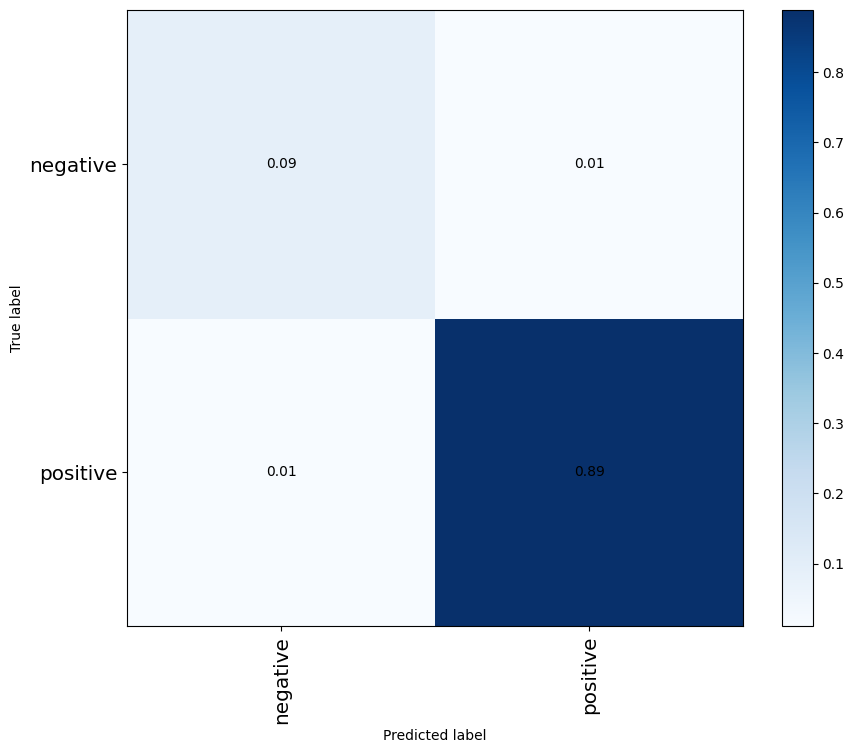

              precision    recall  f1-score   support

    negative       0.88      0.88      0.88      6604
    positive       0.99      0.99      0.99     59635

    accuracy                           0.98     66239
   macro avg       0.94      0.94      0.94     66239
weighted avg       0.98      0.98      0.98     66239



In [43]:
report_classification_results(params, labels_test, preds_test)

A downside is certainly the tremendous amount of training time that was needed to fine tune the model. On the other hand the base model on a tremendous amount of data and knows a lot about language and thus the fine tuned model is likely to generalize.